In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional

from matplotlib.pylab import rcParams

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
rcParams['figure.figsize']=8,6

In [3]:
df = pd.read_csv('/kaggle/input/case-ih-time-series-data/data.csv', index_col=['date'], parse_dates=['date'])

In [4]:
df.head()

,work,income
date,,
2021-09-30,2,2100
2021-10-03,1,3600
2021-10-04,1,4000
2021-10-05,1,7900
2021-10-06,1,7500


In [5]:
df.index

DatetimeIndex(['2021-09-30', '2021-10-03', '2021-10-04', '2021-10-05',
               '2021-10-06', '2021-10-07', '2021-10-08', '2021-10-09',
               '2021-10-10', '2021-10-11',
               ...
               '2022-06-28', '2022-06-30', '2022-07-01', '2022-07-02',
               '2022-07-03', '2022-07-04', '2022-07-05', '2022-07-06',
               '2022-07-07', '2022-07-08'],
              dtype='datetime64[ns]', name='date', length=192, freq=None)

In [6]:
df.shape

(192, 2)

In [7]:
df = df[['income']]

In [8]:
df.shape

(192, 1)

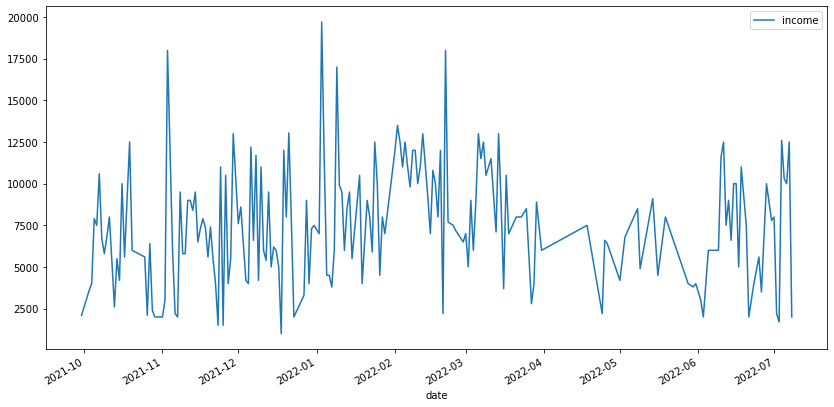

In [9]:
ax = df.plot(figsize=(14, 7))

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))

df = scaler.fit_transform(df)

In [11]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size

train = df[0:train_size,:]
test = df[train_size:len(df),:]

In [12]:
# convert an array of values into a dataset matrix - generating lags from the time series
def create_dataset(df, look_back=1):
    
    dataX, dataY = [], []
    
    for i in range(len(df)-look_back-1):
        a = df[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(df[i + look_back, 0])
        
    return np.array(dataX), np.array(dataY)
  
  # reshape into X=t and Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [13]:
print(trainX.shape)

(122, 30)


In [14]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [15]:
model=Sequential()

model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=(look_back,1)))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='sigmoid', return_sequences=False))

model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')

2023-01-31 07:38:07.447513: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
Xdata_train=[]
Ydata_train=[]

Xdata_train, Ydata_train = create_dataset(train, look_back)
Xdata_train = np.reshape(Xdata_train, (Xdata_train.shape[0], Xdata_train.shape[1], 1))

#training for all data
history = model.fit(Xdata_train,Ydata_train,batch_size=1,epochs=200,shuffle=False)

2023-01-31 07:38:07.905581: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
122/122 [==============================] - 6s 20ms/step - loss: 0.0992
Epoch 2/200
122/122 [==============================] - 2s 19ms/step - loss: 0.0559
Epoch 3/200
122/122 [==============================] - 2s 18ms/step - loss: 0.0560
Epoch 4/200
122/122 [==============================] - 2s 18ms/step - loss: 0.0516
Epoch 5/200
122/122 [==============================] - 2s 18ms/step - loss: 0.0456
Epoch 6/200
122/122 [==============================] - 2s 18ms/step - loss: 0.0410
Epoch 7/200
122/122 [==============================] - 2s 18ms/step - loss: 0.0389
Epoch 8/200
122/122 [==============================] - 2s 18ms/step - loss: 0.0416
Epoch 9/200
122/122 [==============================] - 2s 18ms/step - loss: 0.0426
Epoch 10/200
122/122 [==============================] - 2s 18ms/step - loss: 0.0388
Epoch 11/200
122/122 [==============================] - 2s 19ms/step - loss: 0.0405
Epoch 12/200
122/122 [==============================] - 2s 18ms/step - loss: 0.0424
E

In [17]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3414.34 RMSE
Test Score: 3939.83 RMSE


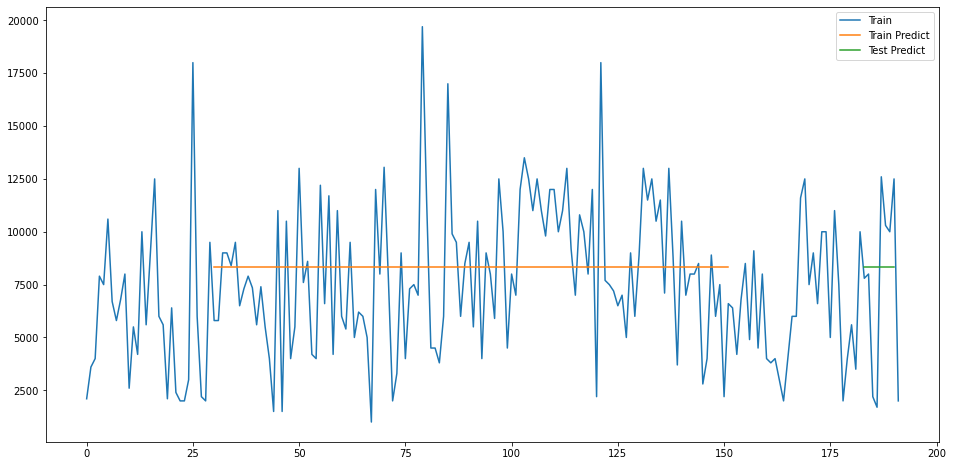

In [18]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(16,8))

plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

plt.legend(['Train','Train Predict','Test Predict'],loc='best')

plt.show()